# 감성 분석 + ML + DL

In [ ]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 1.4 MB/s 
     |████████████████████████████████| 448 kB 46.1 MB/s 


In [ ]:
!wget https://github.com/rickiepark/python-machine-learning-book-3rd-edition/raw/master/ch08/ratings_train.txt -O ratings_train.txt
!wget https://github.com/rickiepark/python-machine-learning-book-3rd-edition/raw/master/ch08/ratings_train.txt -O ratings_test.txt

--2022-03-06 15:42:07--  https://github.com/rickiepark/python-machine-learning-book-3rd-edition/raw/master/ch08/ratings_train.txt
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rickiepark/python-machine-learning-book-3rd-edition/master/ch08/ratings_train.txt [following]
--2022-03-06 15:42:07--  https://raw.githubusercontent.com/rickiepark/python-machine-learning-book-3rd-edition/master/ch08/ratings_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14628807 (14M) [text/plain]
Saving to: ‘ratings_train.txt’

ratings_train.txt   100%[===================>]  13.95M  --.-KB/s    in 0.1s    



In [ ]:
import pandas as pd

train_df = pd.read_csv('./ratings_train.txt', sep='\t')
train_df = train_df.iloc[0:2000, :]
train_df.head(3)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0


In [ ]:
train_df['label'].value_counts( )

0    1011
1     989
Name: label, dtype: int64

In [ ]:
import re

train_df = train_df.fillna(' ')
# 정규 표현식을 이용하여 숫자를 공백으로 변경(정규 표현식으로 \d 는 숫자를 의미함.) 
train_df['document'] = train_df['document'].apply( lambda x : re.sub(r"\d+", " ", x) )

# 테스트 데이터 셋을 로딩하고 동일하게 Null 및 숫자를 공백으로 변환
test_df = pd.read_csv('./ratings_test.txt', sep='\t')
test_df = test_df.iloc[0:800,:]
test_df = test_df.fillna(' ')
test_df['document'] = test_df['document'].apply( lambda x : re.sub(r"\d+", " ", x) )

In [ ]:
from konlpy.tag import Okt

twitter = Okt()
def tw_tokenizer(text):
    # 입력 인자로 들어온 text 를 형태소 단어로 토큰화 하여 list 객체 반환
    tokens_ko = twitter.morphs(text)
#    tokens_ko = twitter.nouns(text)
    return tokens_ko

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Okt 객체의 morphs( ) 객체를 이용한 tokenizer를 사용. ngram_range는 (1,2)도 추후 시도
tfidf_vect = TfidfVectorizer(tokenizer=tw_tokenizer, min_df=3)
tfidf_vect.fit(train_df['document'])
tfidf_matrix_train = tfidf_vect.transform(train_df['document'])

# 학습 데이터를 적용한 TfidfVectorizer를 이용하여 테스트 데이터를 TF-IDF 값으로 Feature 변환함. 
tfidf_matrix_test = tfidf_vect.transform(test_df['document'])

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


In [ ]:
tfidf_matrix_train.shape

(2000, 1419)

In [ ]:
# Logistic Regression 을 이용하여 감성 분석 Classification 수행. 
lg_clf = LogisticRegression(random_state=0)

# Parameter C 최적화를 위해 GridSearchCV 를 이용. 
params = { 'C': [1 ,3.5, 4.5 ] }
grid_cv = GridSearchCV(lg_clf , param_grid=params , cv=10 ,scoring='accuracy', verbose=1 )
grid_cv.fit(tfidf_matrix_train , train_df['label'] )
print(grid_cv.best_params_ , round(grid_cv.best_score_,4))

Fitting 10 folds for each of 3 candidates, totalling 30 fits
{'C': 3.5} 0.755


In [ ]:
grid_cv.best_estimator_

LogisticRegression(C=3.5, random_state=0)

In [ ]:
from sklearn.metrics import accuracy_score

# classifier 는 GridSearchCV에서 최적 파라미터로 학습된 classifier를 그대로 이용
best_estimator = grid_cv.best_estimator_
preds = best_estimator.predict(tfidf_matrix_test)

print('Logistic Regression 정확도: ',accuracy_score(test_df['label'],preds))

Logistic Regression 정확도:  0.92625


In [ ]:
#모델링
from keras import optimizers
from keras.layers import Dense,Dropout
from tensorflow.keras.models import Sequential
from tensorflow import keras
from keras import models
from keras import layers

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

dtm_train = tfidf_matrix_train.todense()
dtm_test = tfidf_matrix_test.todense()

num_classes = 2
y_train = tf.keras.utils.to_categorical(train_df['label'], num_classes)
y_test = tf.keras.utils.to_categorical(test_df['label'], num_classes)

In [ ]:
model = Sequential()
model.add(Dense(300, activation="relu",input_dim=(tfidf_matrix_train.shape[1])))
model.add(Dropout(0.5))

model.add(Dense(2,activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
history_dnn = model.fit(dtm_train, y_train,
          batch_size=32,
          epochs=10, 
          verbose=1)

#모형평가
model.evaluate(dtm_test, y_test, verbose=0)


Epoch 1/10
63/63 [==============================] - 1s 4ms/step - loss: 0.6779 - accuracy: 0.6155
Epoch 2/10
63/63 [==============================] - 0s 4ms/step - loss: 0.5701 - accuracy: 0.8080
Epoch 3/10
63/63 [==============================] - 0s 4ms/step - loss: 0.4106 - accuracy: 0.8515
Epoch 4/10
63/63 [==============================] - 0s 4ms/step - loss: 0.3103 - accuracy: 0.8830
Epoch 5/10
63/63 [==============================] - 0s 4ms/step - loss: 0.2454 - accuracy: 0.9170
Epoch 6/10
63/63 [==============================] - 0s 4ms/step - loss: 0.1984 - accuracy: 0.9375
Epoch 7/10
63/63 [==============================] - 0s 4ms/step - loss: 0.1682 - accuracy: 0.9435
Epoch 8/10
63/63 [==============================] - 0s 4ms/step - loss: 0.1408 - accuracy: 0.9590
Epoch 9/10
63/63 [==============================] - 0s 4ms/step - loss: 0.1209 - accuracy: 0.9620
Epoch 10/10
63/63 [==============================] - 0s 4ms/step - loss: 0.1046 - accuracy: 0.9660


[0.08383682370185852, 0.9737499952316284]

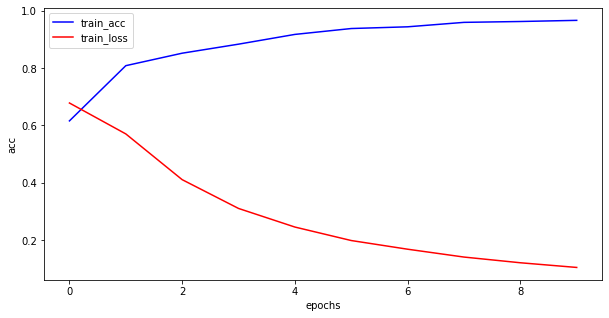

In [ ]:
#---------------------------------------------#
#학습결과 그려보기
import matplotlib.pyplot as plt

# 학습 및 검증 정확도 그리기
acc_dnn = his_dict_dnn['accuracy']
loss_dnn = his_dict_dnn['loss']

fig = plt.figure(figsize= (10,5) )
ax2 = fig.add_subplot(1,1,1)
ax2.plot(np.arange(0,10), acc_dnn, color = 'blue', label = 'train_acc')
ax2.plot(np.arange(0,10), loss_dnn, color = 'red', label = 'train_loss')
ax2.set_xlabel('epochs')
ax2.set_ylabel('acc')
ax2.legend()


# 실습
- 사용하는 데이터의 행수를 2000개에서 3000개로 늘려서 수행해보세요
- ngram을 (1,2)를 지정해보세요
- 형태소 분석된 결과를 사용하는 경우와, 명사만 사용하는 경우를 비교해보세요
- DL의 경우 은닉층을 개선해보세요
